## 任务11：使用PyTorch完成人脸关键点检测
https://gitee.com/coggle/competition-baseline/blob/master/competition/%E7%A7%91%E5%A4%A7%E8%AE%AF%E9%A3%9EAI%E5%BC%80%E5%8F%91%E8%80%85%E5%A4%A7%E8%B5%9B2021/%E4%BA%BA%E8%84%B8%E5%85%B3%E9%94%AE%E7%82%B9%E6%A3%80%E6%B5%8B%E6%8C%91%E6%88%98%E8%B5%9B/face-keypoint2.ipynb

In [1]:
import pandas as pd
import numpy as np

In [2]:
!ls -l ./人脸关键点检测挑战赛_数据集/

total 1023704
-rw-rw-r--@ 1 huazai  staff      49324  8  5 16:54 sample_submit.csv
-rw-rw-r--@ 1 huazai  staff  151068800  7 31 18:11 test.npy
-rw-rw-r--@ 1 huazai  staff     577557  8  5 16:54 train.csv
-rw-rw-r--@ 1 huazai  staff  368640128  7 31 18:11 train.npy


In [4]:
train_df = pd.read_csv('./人脸关键点检测挑战赛_数据集/train.csv')
train_df = train_df.fillna(48)
train_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.342364,38.523613,28.930840,35.577773,49.256845,68.275955,47.783946,85.361582
1,68.912604,31.409117,29.652226,33.028075,51.913358,48.408453,50.698868,79.574038
2,68.708994,40.371149,27.130820,40.940680,44.502523,69.988486,45.926427,86.221009
3,65.334176,35.471878,29.366461,37.767684,50.411373,64.934767,50.028780,74.883241
4,68.634857,29.999486,31.094571,29.616429,50.247429,51.450857,47.948571,84.394286


In [6]:
train_img = np.load('./人脸关键点检测挑战赛_数据集/train.npy')
test_img = np.load('./人脸关键点检测挑战赛_数据集/test.npy')

print(train_img.shape, test_img.shape)

(96, 96, 5000) (96, 96, 2049)


Populating the interactive namespace from numpy and matplotlib


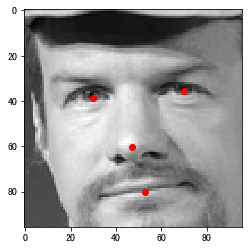

In [7]:
%pylab inline
idx = 409
xy = train_df.iloc[idx].values.reshape(-1, 2)
plt.scatter(xy[:, 0], xy[:, 1], c='r')
plt.imshow(train_img[:, :, idx], cmap='gray')

In [8]:
import os, sys, codecs, glob
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import cv2

import torch
torch.backends.cudnn.benchmark = False
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [9]:
class XunFeiDataset(Dataset):
    def __init__(self, img, keypoint, transform=None):
        self.img = img
        self.transform = transform
        self.keypoint = keypoint
        
    def __getitem__(self, index):
        img = Image.fromarray(self.img[:, :, index]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, self.keypoint[index] / 96.0
    
    def __len__(self):
        return self.img.shape[-1]

In [10]:
train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_img[:, :, :-500], train_df.values[:-500], 
                  transforms.Compose([transforms.ToTensor(),])
    ),
    batch_size=10, shuffle=True, num_workers=5,
)

val_loader = torch.utils.data.DataLoader(
        XunFeiDataset(train_img[:, :, -500:], train_df.values[-500:],
                     transforms.Compose([transforms.ToTensor(),])
        ),
    batch_size = 10, shuffle=False, num_workers=5,
)

In [11]:
train_img[:, :, -500:].shape

(96, 96, 500)

In [12]:
import timm

class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
        self.model = timm.create_model('resnet18', num_classes=8, pretrained=True)
        
    def forward(self, img, labels=None):
        feat = self.model(img)
        return feat
    
model = XunFeiNet()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/huazai/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [13]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    for i, (input, target) in enumerate(train_loader):
        input = input.float()
        target = target.float()
        output = model(input, target)
        loss = criterion(output, target)
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(loss.item())

def validate(val_loader, model):
    model.eval()
    
    val_feats = []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.float()
            target = target.float()
            output = model(input)
            val_feats.append(output.data.cpu().numpy())
        return val_feats

In [14]:
from sklearn.metrics import mean_absolute_error

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.85)
best_acc = 0.0

for epoch in range(5):
    print('Epoch: ', epoch)
    
    train(train_loader, model, criterion, optimizer, epoch)
    
    val_feats = validate(val_loader, model)
    scheduler.step()
    
    val_feats = np.vstack(val_feats) * 96
    print('Val', mean_absolute_error(val_feats, train_df.values[-500:]))

Epoch:  0
0.8691285252571106
0.006475525442510843
0.0021917331032454967
Val 3.433790093241563
Epoch:  1
0.0021954779513180256
0.0011731742415577173
0.003670570207759738
Val 3.518915290887353
Epoch:  2
0.001379505731165409
0.002505925251170993
0.0015628192340955138
Val 3.008628376006146
Epoch:  3
0.0021011908538639545
0.000678642129059881
0.005248866975307465
Val 2.508499253954808
Epoch:  4
0.0012604438234120607
0.0009005451574921608
0.004084402695298195
Val 2.757019575761264


In [15]:
test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_img, np.zeros((2049, 8)),
                  transforms.Compose([transforms.ToTensor(),])
                 ),
    batch_size=10, shuffle=False, num_workers=5,
)

In [17]:
pred_tta = []
for tti in range(1):
    pred = []
    with torch.no_grad():
        for t, (x, y) in enumerate(test_loader):
            x_var = Variable(x)
            y_var = Variable(y)
            scores = model(x_var)
            pred.append(scores.data.cpu().numpy())
    pred = np.concatenate(pred, 0)
    print(tti)
    pred_tta.append(pred)
    
pred = np.mean(pred_tta, axis=0)

0


In [18]:
col = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
 'right_eye_center_y', 'nose_tip_x', 'nose_tip_y', 
 'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y']
pd.DataFrame(pred * 96, columns=col).to_csv('submit.csv', index=None)